# Note: Please refer to 'apply_lda_v3' for a more modeling details

In [1]:
# generic
import pandas as pd
import numpy as np

import os
import json
import string
from operator import itemgetter
from collections import defaultdict

# text
from textblob import TextBlob
from nltk.corpus import stopwords

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.externals import joblib

# how about we combined many texts together and try this out

In [2]:
path = os.getcwd()+'\\data'
fileList = os.listdir(path)

# in the part of file 'speech_data_pull_v3.ipynb' I have 
pathToFile = path + '\\' + 'bulkSpeeches.txt'
with open(pathToFile, 'r') as f:
    txt = f.readlines()

In [3]:
txtList = txt[0].split('.')
txtList[:5]
len(txtList)

30145

In [4]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']

def stringClean(str):
    str = ''.join([i for i in str if i not in string.punctuation])
    words = TextBlob(str).words
    words = ' '.join([w for w in words if w not in stop if len(w)> 1])
    
    return words

updatedTextList = []
for txt in txtList:
    updatedTextList.append(stringClean(txt))
    
updatedTextList[:5]

['Wherever go talk need bring real change country',
 'And understand need change well folks Michigan',
 'Because weve talking recession country months Michigan living long time',
 'Michigan highest unemployment rate nation workers communities across state struggling years downturn America feeling today',
 'In fairness challenges product larger forces beyond control government']

In [5]:
len(updatedTextList)

30145

In [6]:
lda_docs_unpickled = joblib.load('model_data/lda_docs.pkl')

In [7]:
lda_doc_test = lda_docs_unpickled[0]

In [8]:
def getSentence(sentence):
    return sorted(sentence, key=itemgetter(1), reverse=True)[0][0]

sentenceAndTopicList = []
for index, doc in enumerate(lda_docs_unpickled):
    temp = [index, getSentence(doc)]
    sentenceAndTopicList.append(temp)
    
sentenceAndTopicList[:20]
len(sentenceAndTopicList)
#getSentence(lda_doc_test)

30145

In [9]:
def getSentenceFromIndex(data, textList):
    return textList[data]

df = pd.DataFrame(sentenceAndTopicList)
df.rename(columns={0: 'docIndex', 1: 'topic'}, inplace=True)
#df['sentence'] = df.apply(lambda row: getSentenceFromIndex(row.docIndex, updatedTextList), axis=1)
df['sentence'] = df.apply(lambda row: getSentenceFromIndex(row.docIndex, txtList), axis=1)
df.sort(['topic'], ascending=True, inplace=True)
df[df['topic']==2].head()

C:\Python34\Lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,docIndex,topic,sentence
22122,22122,2,"It's time for us to say, Enough is enough! No..."
9323,9323,2,We traveled because God was with us
9317,9317,2,It's a prayer for a journey
17811,17811,2,The overarching strategy is not something tha...
17079,17079,2,It is to determine the strategy and then to a...


In [10]:
# this is just to check out how sentences are in topic 1
topic1 = []
df_topic1 = df[df['topic'] == 1]
topic1_sentences = list(df_topic1.iloc[:,2].values)

topic1_sentences[:5]

[' I will reform our health care system so we can relieve families, businesses, and our economy from the crushing cost of health care by investing in new technology and preventative care',
 ' In the Senate, I worked across the aisle to crack down on these schemes',
 ' If you have health care, my plan will lower your premiums',
 ' Other nations would feel great pressure to accommodate Iranian demands',
 " And, you know, I've seen and heard worse"]

## How about making dictionary of all the topics

In [11]:
'''
topicDict
---------
key: topic number
value: list of sentences that belong to above topic
'''
topicDict = {}

numOfTopics = 10
for i in range(numOfTopics):
    df_topic = df[df['topic'] == i]
    topic_sentences = list(df_topic.iloc[:,2].values)

    topicDict[i] = topic_sentences
    
topicDict[2][:5]

[" It's time for us to say, Enough is enough! Now my opponent wants to have a debate about change, and that's a debate that I welcome",
 ' We traveled because God was with us',
 " It's a prayer for a journey",
 ' The overarching strategy is not something that I can deflect to the general',
 ' It is to determine the strategy and then to ask our military to carry it out']

In [12]:
def convertCharToLower(numOfTopics):
    for i in range(numOfTopics):
        topicDict[i] = [i.lower().strip() for i in topicDict[i]]
        
def putSentenceTags(numOfTopics):
    for i in range(numOfTopics):
        topicDict[i] = ['START HERE ' + i + ' STOP NOW' for i in topicDict[i]]
        
def cleanPunctuation(numOfTopics):
    for punct in string.punctuation:
        for i in range(numOfTopics):
            topicDict[i] = [sentence.replace(punct, '') for sentence in topicDict[i]]

def applyStringTransform(numOfTopics):
    convertCharToLower(numOfTopics)
    cleanPunctuation(numOfTopics)
    putSentenceTags(numOfTopics)
    
applyStringTransform(10)

topicDict[1][:5]

['START HERE i will reform our health care system so we can relieve families businesses and our economy from the crushing cost of health care by investing in new technology and preventative care STOP NOW',
 'START HERE in the senate i worked across the aisle to crack down on these schemes STOP NOW',
 'START HERE if you have health care my plan will lower your premiums STOP NOW',
 'START HERE other nations would feel great pressure to accommodate iranian demands STOP NOW',
 'START HERE and you know ive seen and heard worse STOP NOW']

In [13]:
# ======= (4) Start doing n-grams
# chooseTopic = 8
# docList = ['START HERE ' + i + ' STOP NOW' for i in topicDict[chooseTopic]]

def find_ngrams(input_string, n):
    # replace double space by single space
    input_string = input_string.replace('  ', ' ')
    input_list = input_string.split(' ')
    return zip(*[input_list[i:] for i in range(n)])

# ======= (5) Start doing n-grams

def generateNGramDict(docList):
    d = defaultdict(list)
    for doc in docList:
        trigrams = list(find_ngrams(doc,3))
        for trigram in trigrams:
            d[trigram[:2]].append(trigram[2])
            
    return d

'''
nGramDict
---------
why? we are breaking the sentences into trigram and using the first two as key.
     This is a dictionary where for each key value [0 to 9] we have a defaultdict
     of key, value pairs where key is a tuple of first two trigram words and then 
     value is list of words that follow.
key   = topic,
value =  value = defaultdict [which itself if key=(word1, word2), value = [list of all values that come next]]
'''

nGramDict = {}
for i in range(10):
    dtemp = generateNGramDict(topicDict[i])
    nGramDict[i] = dtemp

# ======= (6) Test sentence generator

def generateText(triGramDict, firstWord='START', secondWord='HERE'):
    newSpeech = [firstWord,secondWord]
    
    while secondWord != 'NOW':
        firstWord, secondWord = secondWord, np.random.choice(triGramDict[(firstWord, secondWord)])
        newSpeech.append(secondWord)
        
    return newSpeech[2:-2] 

In [14]:
nGramDict

{0: defaultdict(list,
             {('more', 'of'): ['the', 'this', 'that', 'that', 'you'],
              ('less', 'effective'): ['in'],
              ('new', 'project'): ['of'],
              ('of', 'evils'): ['been'],
              ('entering', 'an'): ['era'],
              ('a', 'womens'): ['event', 'event'],
              ('washingtonspeak', 'for'): ['well', 'well', 'it'],
              ('subsidized', 'travel'): ['on', 'on', 'on'],
              ('military', 'force'): ['against', 'STOP'],
              ('nuclear', 'reactors'): ['without'],
              ('are', 'still'): ['not',
               'about',
               'some',
               'going',
               'living',
               'not',
               'earths',
               'trying',
               'suspicions',
               'going'],
              ('the', 'individual'): ['STOP'],
              ('asks', 'everything'): ['of', 'of'],
              ('iraq', 'in'): ['perpetuity'],
              ('more', 'efficiently'): ['an

In [15]:
joblib.dump(nGramDict, 'nGramDict.pkl')

['nGramDict.pkl']

In [16]:
# ======= (7) Generate pair of sentences
result = True
while result:
    sentence_1 = generateText(nGramDict[2])
    sentence_2 = generateText(nGramDict[2])
    unique_words_1 = set(sentence_1)
    unique_words_2 = set(sentence_2)
    if len(unique_words_1.intersection(unique_words_2)) > 10:
    #if (len(unique_words_1.intersection(unique_words_2))) / (len(unique_words_1.union(unique_words_2))) > 0.3:
        print(' '.join(sentence_1))
        print('------------------')
        print(' '.join(sentence_2))
        result = False

hes gone through all kinds of complexity and effective diplomatic work that we saw that morning forced us to concern ourselves with the same place as the leader who is so badly needed than in iraq and there is a set of reflections by at least a politician as are out there
------------------
when the lunch bucket crowd really wants to know that we have the option of purchasing a number of years ago they told me about as i do the same problems abroad so that we can grow the economic pie and have decided that change must come to these shores against great odds and carve a new life for their families in america is that life doesnt count for much unless youre a civil war in iraq as we welcome competition we need to crack down on trading activity that crosses the line to market manipulation


# EDA

- clean up all sentences in txtList
- remember that txtList is a list of sentences where we have from the 2008 campaign speeches
- I want to get all the individual documents
- Once user puts in a string or set of strings, I want to see which topic they are likely to belong to

### Do not think I will need the following section
#### Skip to the vectorizer section

In [17]:
cleanedTxtList = []

def cleanUpText(textList):
    for sentence in textList:
        for punct in string.punctuation:
            sentence = sentence.replace(punct, '')
        sentence = sentence.strip()
        cleanedTxtList.append(sentence)
    return cleanedTxtList

cleanUpText(txtList)
cleanedTxtList[:5]

['Wherever I go I talk about how we need to bring about real change in this country',
 'And few understand the need for change as well as folks here in Michigan',
 'Because while weve been talking about a recession in this country for a few months now Michigan has been living it for a very long time',
 'Michigan has the highest unemployment rate in the nation and workers and communities across this state have been struggling for years with the downturn that all of America is feeling today',
 'In fairness some of these challenges are the product of larger forces beyond the control of government']

In [18]:
vectorizer = CountVectorizer(min_df=1, lowercase=True)

In [19]:
x = vectorizer.fit_transform(topicDict[9]).toarray()
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
df = pd.DataFrame(x, columns=vectorizer.get_feature_names())
df[df['iraq'] > 0]['iraq'].count()

118

How about a function that gives the count of word in all topics

In [21]:
def wordInTopicCounter(word, topicDict):
    '''
    - given word and topicDict generate the total count of word in each topic
    - example of output: [(0, 96), (1, 38), (2, 81), (3, 56), (4, 31), (5, 10), (6, 35), (7, 64), (8, 135), (9, 118)]
    - based on output for 'iraq' we see topic=0 had 96 mentions of 'iraq'....
    '''
    wordFreqInTopicList = []
    
    for num in range(10):
        x = vectorizer.fit_transform(topicDict[num]).toarray()
        df = pd.DataFrame(x, columns=vectorizer.get_feature_names())
        
        if word in vectorizer.get_feature_names():
            wordFreqInTopicList.append((num,df[df[word] > 0][word].count()))
        else:
            wordFreqInTopicList.append((num, 0))
            
    return wordFreqInTopicList

def mostPopularTopicsByWord(word, topicDict):
    '''
    - we want to use the wordInTopicCounter to give the count
      of word in each topic
    - we then want to sort in descending
    - output the first three
    - example output: based on same sample as above, [(8, 135), (9, 118), (0, 96)]
    '''
    wordInTopicArray = wordInTopicCounter(word.lower(), topicDict)      
    return sorted(wordInTopicArray, key=itemgetter(1), reverse=True)[:3]

print(wordInTopicCounter('iraq', topicDict))
mostPopularTopicsByWord('iraq', topicDict)

[(0, 96), (1, 38), (2, 81), (3, 56), (4, 31), (5, 10), (6, 35), (7, 64), (8, 135), (9, 118)]


[(8, 135), (9, 118), (0, 96)]

In [22]:
def wordInTopicCounter(word, topicDict):
    '''
    - given word and topicDict generate the total count of word in each topic
    - example of output: [(0, 96), (1, 38), (2, 81), (3, 56), (4, 31), (5, 10), (6, 35), (7, 64), (8, 135), (9, 118)]
    - based on output for 'iraq' we see topic=0 had 96 mentions of 'iraq'....
    '''
    wordFreqInTopicList = []
    
    for num in range(10):
        x = vectorizer.fit_transform(topicDict[num]).toarray()
        df = pd.DataFrame(x, columns=vectorizer.get_feature_names())
        
        if word in vectorizer.get_feature_names():
            wordFreqInTopicList.append(df[df[word] > 0][word].count()/len(df))
        else:
            wordFreqInTopicList.append(0)
            
    return wordFreqInTopicList

#campaignWords = ['iraq','war','tax','senator','bush','energy','economy','jobs','health','change','contibutions','climate']
campaignWords = ['iraq','war','jobs','senator','tax','bush','economy','health','change','oil','energy','climate']
campaignWordsInTopicSpace = defaultdict(list)
for word in campaignWords:
    campaignWordsInTopicSpace[word].append(wordInTopicCounter(word, topicDict))


In [23]:
campaignWordsInTopicSpace[campaignWords[11]][0]

[0.010566546762589928,
 0.0011755485893416929,
 0.002926115581565472,
 0.00033057851239669424,
 0.0033682634730538923,
 0,
 0.0005201560468140442,
 0.001052262364082778,
 0.0039173789173789176,
 0.0022692889561270802]

In [24]:
campaignWords[11]

'climate'

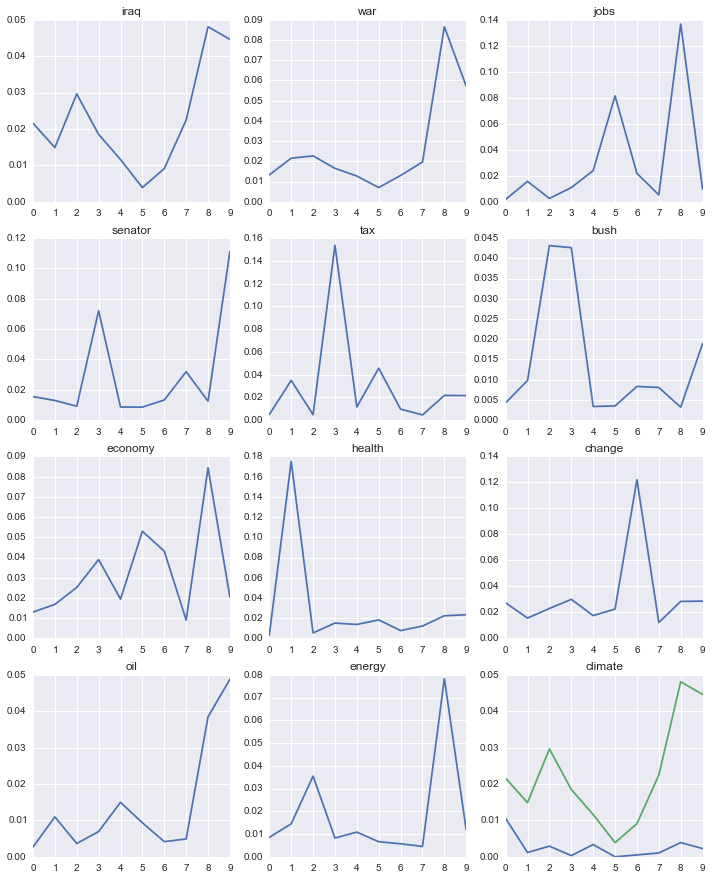

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(4, 3, figsize=(12,15))  # 2 Rows, 1 Col
x = range(10)

ax[0,0].set_title(campaignWords[0])
ax[0,0].plot(x, campaignWordsInTopicSpace[campaignWords[0]][0])
ax[0,1].set_title(campaignWords[1])
ax[0,1].plot(x, campaignWordsInTopicSpace[campaignWords[1]][0])
ax[0,2].set_title(campaignWords[2])
ax[0,2].plot(x, campaignWordsInTopicSpace[campaignWords[2]][0])

ax[1,0].set_title(campaignWords[3])
ax[1,0].plot(x, campaignWordsInTopicSpace[campaignWords[3]][0])
ax[1,1].set_title(campaignWords[4])
ax[1,1].plot(x, campaignWordsInTopicSpace[campaignWords[4]][0])
ax[1,2].set_title(campaignWords[5])
ax[1,2].plot(x, campaignWordsInTopicSpace[campaignWords[5]][0])

ax[2,0].set_title(campaignWords[6])
ax[2,0].plot(x, campaignWordsInTopicSpace[campaignWords[6]][0])
ax[2,1].set_title(campaignWords[7])
ax[2,1].plot(x, campaignWordsInTopicSpace[campaignWords[7]][0])
ax[2,2].set_title(campaignWords[8])
ax[2,2].plot(x, campaignWordsInTopicSpace[campaignWords[8]][0])



ax[3,0].set_title(campaignWords[9])
ax[3,0].plot(x, campaignWordsInTopicSpace[campaignWords[9]][0])
ax[3,1].set_title(campaignWords[10])
ax[3,1].plot(x, campaignWordsInTopicSpace[campaignWords[10]][0])
ax[3,2].set_title(campaignWords[11])
ax[3,2].plot(x, campaignWordsInTopicSpace[campaignWords[11]][0])


# ax[1].scatter(y, log_pred_vals)
# ax[1].set_title('Log Model, Actual vs. Predicted')
# ax[1].plot(line, line)
# ax[1].set_xlabel('Actual')
# ax[1].set_ylabel('Predicted')

plt.plot(x, campaignWordsInTopicSpace[campaignWords[0]][0])

In [26]:
def generateSentencesFromRelevantTopics(word, topicDict):
    '''
    - here is an example of output for word='china'
    ['china but we too often theyve been stories of struggle and sacrifice for that you might be forced to raise me and the values of that cross inside the thousands of young people because youre part of various terrorist networks that we have one of the other day',
     '',
     'HERE china is not the solution',
     '',
     'china already has higher fuel efficiency standards and opposed legislation that creates a gulf coast where poverty thrived long before katrina came ashore',
     ''
     ]
     - give it a word and it will go through all the topics and generate a sentence from the most relevant ones 
    '''
    word = word.lower()
    #startTuple = []
    sentenceList = []
    popularTopicsByWord = mostPopularTopicsByWord(word, topicDict)
    for topic in popularTopicsByWord:
        startTuple = []
        for key, _ in nGramDict[topic[0]].items():
            if word in key:
                startTuple.append(key)

                
        startSeed = startTuple[np.random.choice(len(startTuple))]
        sentence = ' '.join([startSeed[0], startSeed[1]] + generateText(nGramDict[topic[0]], firstWord=startSeed[0], secondWord=startSeed[1]))
        sentenceList.append(sentence)
        sentenceList.append('')
    return sentenceList

generateSentencesFromRelevantTopics('jobs', topicDict)

IndexError: invalid index to scalar variable.

# EDA II

In [ ]:
vectorizer = CountVectorizer(stop_words='english', min_df=1, lowercase=True)
x = vectorizer.fit_transform(topicDict[9]).toarray()
df = pd.DataFrame(x, columns=vectorizer.get_feature_names())
column_sum_of_countVectorized_df = df.sum(axis=0)

df2 = pd.DataFrame(column_sum_of_countVectorized_df)
result = df2.sort([0], ascending=[0])
#result.iloc[:,0]
result[(result.iloc[:,0]>100) & (result.iloc[:,0]<1000)][0]

In [ ]:
mostPopularTopicsByWord('iraq', topicDict)

## -------------------------------------- Rough -------------------------------